# Run simple simulation via perturb nr2f5 targets

## Library imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import torch
import random
import anndata as ad

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
import sklearn

import cellrank as cr
import scanpy as sc
import scvi
import regvelo
from regvelo import REGVELOVI
import regvelo as rgv

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import set_output
from rgv_tools.perturbation import in_silico_block_simulation
from rgv_tools.perturbation import inferred_GRN,abundance_test
from rgv_tools.perturbation import get_list_name, TFScanning

/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/regve

## General settings

In [2]:
%matplotlib inline

In [3]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


## Constants

In [4]:
DATASET = "zebrafish"

In [5]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

In [6]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [7]:
genes = ["nr2f5", "sox9b", "twist1b", "ets1"]

In [8]:
TERMINAL_STATES = [
    "mNC_head_mesenchymal",
    "mNC_arch2",
    "mNC_hox34",
    "Pigment",
]

In [9]:
MODEL = DATA_DIR / DATASET / "processed" / "rgv_model"

## Define functions

In [10]:
def cosine_similarity(vector_a, vector_b):
    """
    Calculate the cosine similarity between two vectors.

    Args:
        vector_a (np.array): First vector.
        vector_b (np.array): Second vector.

    Returns:
        float: Cosine similarity between vector_a and vector_b.
    """
    dot_product = np.dot(vector_a, vector_b)
    norm_a = np.linalg.norm(vector_a)
    norm_b = np.linalg.norm(vector_b)
    
    return dot_product / (norm_a * norm_b)

## Data loading

In [11]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_preprocessed.h5ad")

## Load model

In [12]:
# Prepare skeleton
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

# Prepare TF
TF = adata.var_names[adata.var["TF"]]

# Prepare model
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = REGVELOVI(adata, W=W.T, regulators=TF, soft_constraint=False)

In [13]:
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2359.505. Signaling Trainer to stop.


In [14]:
vae.save(MODEL)

In [15]:
vae = REGVELOVI.load(MODEL,adata)

INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/zebrafish_regulon_
         traj/processed/rgv_model/model.pt already downloaded                                                      


In [16]:
set_output(adata, vae, n_samples=30, batch_size=adata.n_obs)

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2025-10-25 21:33:19,025 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


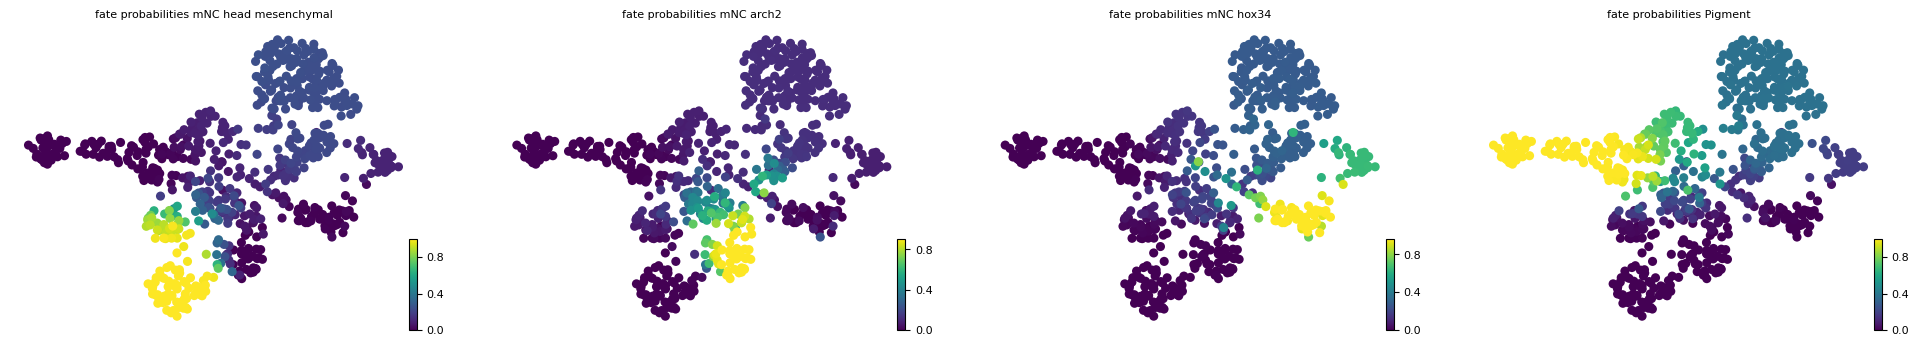

In [17]:
TERMINAL_STATES = ["mNC_head_mesenchymal",
                  "mNC_arch2",
                  "mNC_hox34",
                  "Pigment"]
vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

estimator = cr.estimators.GPCCA(vk)

## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=7, cluster_key="cell_type")
estimator.set_terminal_states(TERMINAL_STATES)
estimator.compute_fate_probabilities()
estimator.plot_fate_probabilities(same_plot=False)

In [18]:
lineage_genes = estimator.compute_lineage_drivers(return_drivers=True, cluster_key="cell_type")

In [19]:
adata_perturb_dict = {}
reg_vae_perturb_dict = {}
cand_list = ["nr2f5", "ets1","sox9b","twist1b"]

for TF in cand_list:
    adata_target_perturb, reg_vae_perturb =  in_silico_block_simulation(model=MODEL,
                                                                               adata=adata,
                                                                               gene=TF,
                                                                               cutoff=0)
    adata_perturb_dict[TF] = adata_target_perturb
    reg_vae_perturb_dict[TF] = reg_vae_perturb

INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/zebrafish_regulon_
         traj/processed/rgv_model/model.pt already downloaded                                                      
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/zebrafish_regulon_
         traj/processed/rgv_model/model.pt already downloaded                                                      
INFO     File                                                                                                      
         /lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/GRN_trajectory_benchmark/data/zebrafish_regulon_
         traj/processed/rgv_model/model.pt already downloaded           

In [20]:
ct_indices = {
    ct: adata.obs["term_states_fwd"][adata.obs["term_states_fwd"] == ct].index.tolist()
    for ct in TERMINAL_STATES}

# Computing states transition probability for perturbed systems
for TF, adata_target_perturb in adata_perturb_dict.items():
    vkp = cr.kernels.VelocityKernel(adata_target_perturb).compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata_target_perturb).compute_transition_matrix()

    estimator = cr.estimators.GPCCA(vkp)
    estimator.set_terminal_states(ct_indices)
    estimator.compute_fate_probabilities()

    adata_perturb_dict[TF] = adata_target_perturb

  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/697 [00:00<?, ?cell/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/4 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


## Select top-20 targets

In [21]:
W = pd.DataFrame(vae.module.v_encoder.fc1.weight.data.cpu().numpy(),index = adata.var_names,columns = adata.var_names)

In [22]:
targets = W.sort_values(by='nr2f5', ascending=False).loc[:,"nr2f5"]
targets = targets[:20].index

In [23]:
targets

Index(['kalrnb', 'lmo4b', 'zfhx4', 'hsp70.3', 'serpinh1b', 'afap1l1b',
       'zgc:153867', 'pdlim1', 'cyth1b', 'sept12', 'hsp70.2', 'tuba1a',
       'alcama', 'parp12b', 'adgrl1a', 'emc2', 'col4a6', 'ptprub', 'lsp1a',
       'slbp'],
      dtype='object', name='Gene')

Both `serpinh1b` and `alcama` genes are known functional related to skeleton development, in which closely relate to facial mesenchymal

alcama: https://pmc.ncbi.nlm.nih.gov/articles/PMC3036164/
serpinh1b: https://www.sciencedirect.com/science/article/pii/S0925477315000489?utm_source=chatgpt.com

In [24]:
Wp_p = W.copy()
for g in ['alcama','serpinh1b']:
    Wp_p.loc[g,"nr2f5"] = 0

In [25]:
reg_vae_perturb_dict["nr2f5"].module.v_encoder.fc1.weight.data = torch.tensor(np.array(Wp_p),device = "cuda:0")

In [26]:
set_output(adata_perturb_dict["nr2f5"], reg_vae_perturb_dict["nr2f5"], n_samples=30, batch_size=adata.n_obs)

## Run ODE simulation

In [27]:
adata_perturb_dict["nr2f5"].layers["fit_s"],adata_perturb_dict["nr2f5"].layers["fit_u"] = reg_vae_perturb_dict["nr2f5"].rgv_expression_fit(n_samples = 30)

In [28]:
adata.layers["fit_s"],adata.layers["fit_u"] = vae.rgv_expression_fit(n_samples = 30)

## Calculating similarity

In [29]:
velo = adata_perturb_dict["nr2f5"][adata.obs_names[adata.obs["cell_type"] == "NPB_nohox"]].layers["velocity"]
gex = adata[adata.obs_names[adata.obs["cell_type"] == "NPB_nohox"]].layers["fit_s"]

In [30]:
gex = gex + velo

cor_pert = []
for i in range(47):
    cor_pert.append(cosine_similarity(gex[i,],adata[adata.obs["term_states_fwd"] == "mNC_head_mesenchymal"].layers["fit_s"].mean(0)))

In [31]:
velo = adata[adata.obs_names[adata.obs["cell_type"] == "NPB_nohox"]].layers["velocity"]
gex = adata[adata.obs_names[adata.obs["cell_type"] == "NPB_nohox"]].layers["Ms"]

In [32]:
gex = gex + velo

cor_raw = []
for i in range(47):
    cor_raw.append(cosine_similarity(gex[i,],adata[adata.obs["term_states_fwd"] == "mNC_head_mesenchymal"].layers["fit_s"].mean(0)))

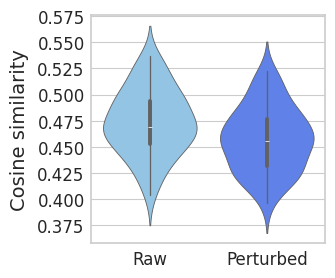

In [33]:
df = pd.DataFrame({
    'Cosine similarity': np.concatenate([cor_pert, cor_raw]),
    'Type': ['Perturbed']*len(cor_pert) + ['Raw']*len(cor_raw)
})

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 3))

    sns.violinplot(
        data=df,
        ax=ax,
        # orient="h",
        x="Type",
        y="Cosine similarity",
        hue = "Type",
        order=["Raw", "Perturbed"],
    )
    
    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "GEX_prediction.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.xlabel("")

In [34]:
scipy.stats.ttest_ind(cor_raw,cor_pert,alternative = "greater")

TtestResult(statistic=2.5447425447525465, pvalue=0.006300639496181312, df=92.0)

## Visualize the cell fate probability change after entire nr2f5 regulon depletion

In [35]:
score = np.array(adata_perturb_dict["nr2f5"].obsm['lineages_fwd']["mNC_head_mesenchymal"]).reshape(-1) - np.array(adata.obsm['lineages_fwd']["mNC_head_mesenchymal"]).reshape(-1)

In [36]:
adata.obs["score"] = score

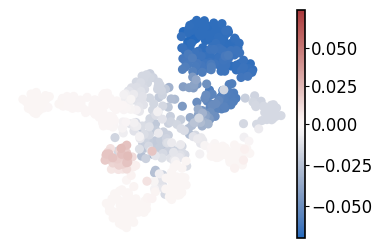

In [37]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4,3))
    sc.pl.umap(adata=adata, color="score", title="",cmap = "vlag",vcenter = 0,ax = ax, vmax = 0.075,frameon=False, legend_fontsize=14)
    
    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "nr2f5_perturbation.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show

## Visualize trajectory

In [38]:
wt = adata.copy()
nr2f5 = adata_perturb_dict["nr2f5"].copy()

In [39]:
gene = "serpinh1b"
X = np.zeros((adata.shape[0],3))
X[:,0] = wt[:,"nr2f5"].layers["Ms"].reshape(-1)
X[:,1] = wt[:,gene].layers["fit_u"].reshape(-1)
X[:,2] = nr2f5[:,gene].layers["fit_u"].reshape(-1)

In [40]:
var = pd.DataFrame({
    'gene_name': ["nr2f5",gene,f'{gene}_pert'],
}, index=["nr2f5",gene,f'{gene}_pert'])

In [41]:
adata_plot = ad.AnnData(X=X, obs=adata.obs.copy(), var=var)

In [42]:
adata_plot.obsm = adata.obsm.copy()
adata_plot.uns = adata.uns.copy()
adata_plot.obsp = adata.obsp.copy()

In [43]:
adata_plot

AnnData object with n_obs × n_vars = 697 × 3
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'cell_type', 'stage', 'latent_time', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'score'
    var: 'gene_name'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'coarse_fwd', 'eigendecomposition_fwd', 'macrostates_fwd_colors', 'neighbors', 'network', 'regulators', 'schur_matrix_fwd', 'skeleton', 'targets', 'term_states_fwd_colors'
    obsm: 'X_pca', 'X_umap', 'macrostates_fwd_memberships', 'schur_vectors_fwd', 'term_states_fwd_memberships', 'lineages_fwd'
    obsp: 'connectivities', 'distances'

In [44]:
model = cr.models.GAMR(adata_plot, n_knots=10, smoothing_penalty=10.0)

2025-10-25 21:35:08,101 - INFO - cffi mode is CFFI_MODE.ANY
2025-10-25 21:35:08,107 - INFO - R home found: /usr/lib64/R
2025-10-25 21:35:08,384 - INFO - R library path: :/home/icb/weixu.wang/miniconda3/lib
2025-10-25 21:35:08,385 - INFO - LD_LIBRARY_PATH: :/home/icb/weixu.wang/miniconda3/lib
2025-10-25 21:35:08,878 - INFO - Default options to initialize R: rpy2, --quiet, --no-save
sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
sh: which: line 1: syntax error: unexpected end of file
sh: error importing function definition for `which'
2025-10-25 21:35:11,436 - INFO - R is already initialized. No need to initialize.


  0%|          | 0/3 [00:00<?, ?gene/s]

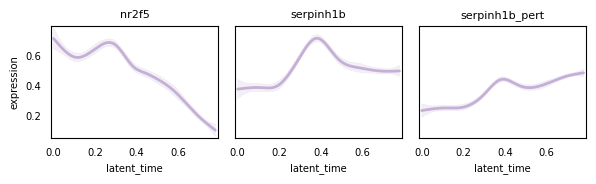

In [45]:
cr.pl.gene_trends(
    adata_plot,
    model=model,
    lineages="mNC_head_mesenchymal",
    data_key="X",
    genes=var.index.tolist(),
    same_plot=True,
    ncols=3,
    time_key="latent_time",
    hide_cells=True,
    weight_threshold=(1e-3, 1e-3),
    legend_loc = "none",
    sharey = True,
    figsize=(6, 2),
)

In [46]:
gene = "alcama"
X = np.zeros((adata.shape[0],3))
X[:,0] = wt[:,"nr2f5"].layers["Ms"].reshape(-1)
X[:,1] = wt[:,gene].layers["fit_u"].reshape(-1)
X[:,2] = nr2f5[:,gene].layers["fit_u"].reshape(-1)

In [47]:
var = pd.DataFrame({
    'gene_name': ["nr2f5",gene,f'{gene}_pert'],
}, index=["nr2f5",gene,f'{gene}_pert'])

In [48]:
adata_plot = ad.AnnData(X=X, obs=adata.obs.copy(), var=var)

In [49]:
adata_plot.obsm = adata.obsm.copy()
adata_plot.uns = adata.uns.copy()
adata_plot.obsp = adata.obsp.copy()

In [50]:
adata_plot

AnnData object with n_obs × n_vars = 697 × 3
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'cell_type', 'stage', 'latent_time', 'macrostates_fwd', 'term_states_fwd', 'term_states_fwd_probs', 'score'
    var: 'gene_name'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'coarse_fwd', 'eigendecomposition_fwd', 'macrostates_fwd_colors', 'neighbors', 'network', 'regulators', 'schur_matrix_fwd', 'skeleton', 'targets', 'term_states_fwd_colors'
    obsm: 'X_pca', 'X_umap', 'macrostates_fwd_memberships', 'schur_vectors_fwd', 'term_states_fwd_memberships', 'lineages_fwd'
    obsp: 'connectivities', 'distances'

In [51]:
model = cr.models.GAMR(adata_plot, n_knots=10, smoothing_penalty=10.0)

  0%|          | 0/3 [00:00<?, ?gene/s]

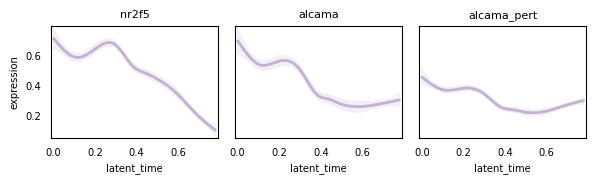

In [52]:
cr.pl.gene_trends(
    adata_plot,
    model=model,
    lineages="mNC_head_mesenchymal",
    data_key="X",
    genes=var.index.tolist(),
    same_plot=True,
    ncols=3,
    time_key="latent_time",
    hide_cells=True,
    weight_threshold=(1e-3, 1e-3),
    legend_loc = "none",
    sharey = True,
    figsize=(6, 2),
)